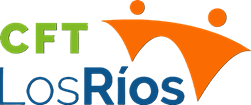
# Taller de Analítica
### Clase 3: Redes Neuronales 
#### Profesor: Diego Miranda Olavarría
#### Data Scientist

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader

# Configurar PyTorch para usar GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el dataset
data = pd.read_csv('iris.csv')
X = data.drop('Species', axis=1).values
y = data['Species'].values

# Convertir las etiquetas a índices
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Convertir a tensores de PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# Dividir los datos en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Crear dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Definir el modelo con dropout
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Instanciar el modelo y moverlo al dispositivo
model = IrisNet().to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Función para entrenar el modelo con dropout
def train(model, criterion, optimizer, loader):
    model.train()
    total_loss = 0
    total_count = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        total_count += data.size(0)
    average_loss = total_loss / total_count
    return average_loss

# Función para evaluar el modelo en el conjunto de datos
def evaluate(model, loader):
    model.eval()
    total_correct = 0
    all_preds = []
    all_y = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze()
            total_correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_y.extend(target.cpu().numpy())

    accuracy = total_correct / len(loader.dataset)
    precision, recall, f1 = calculate_metrics(all_preds, all_y)
    return accuracy, precision, recall, f1


# Función para calcular métricas
def calculate_metrics(preds, targets):
    precision = precision_score(targets, preds, average='weighted', zero_division=1)
    recall = recall_score(targets, preds, average='weighted')
    f1 = f1_score(targets, preds, average='weighted')
    return precision, recall, f1


# Entrenar y evaluar el modelo
epochs = 100
for epoch in range(epochs):
    start_time = time.time()
    train_loss = train(model, criterion, optimizer, train_loader)
    val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader)
    test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader)
    epoch_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{epochs} - Tiempo: {epoch_time:.2f} seg - '
          f'Train Loss: {train_loss:.4f}, '
          f'Val_Acc: {val_accuracy:.4f}, '
          f'Val_Prec: {val_precision:.4f}, '
          f'Val_Rec: {val_recall:.4f}, '
          f'Val_F1: {val_f1:.4f}, '
          f'Test_Acc: {test_accuracy:.4f}, '
          f'Test_Prec: {test_precision:.4f}, '
          f'Test_Rec: {test_recall:.4f}, '
          f'Test_F1: {test_f1:.4f}')


Epoch 1/100 - Tiempo: 0.15 seg - Train Loss: 1.0636, Val_Acc: 0.5333, Val_Prec: 0.8600, Val_Rec: 0.5333, Val_F1: 0.4256, Test_Acc: 0.7333, Test_Prec: 0.8400, Test_Rec: 0.7333, Test_F1: 0.6333
Epoch 2/100 - Tiempo: 0.02 seg - Train Loss: 0.9321, Val_Acc: 0.8000, Val_Prec: 0.8222, Val_Rec: 0.8000, Val_F1: 0.8066, Test_Acc: 0.8667, Test_Prec: 0.8667, Test_Rec: 0.8667, Test_F1: 0.8667
Epoch 3/100 - Tiempo: 0.02 seg - Train Loss: 0.8562, Val_Acc: 0.8000, Val_Prec: 0.8600, Val_Rec: 0.8000, Val_F1: 0.7176, Test_Acc: 0.6000, Test_Prec: 0.8400, Test_Rec: 0.6000, Test_F1: 0.4857
Epoch 4/100 - Tiempo: 0.02 seg - Train Loss: 0.7913, Val_Acc: 0.8000, Val_Prec: 0.8600, Val_Rec: 0.8000, Val_F1: 0.7176, Test_Acc: 0.6000, Test_Prec: 0.8400, Test_Rec: 0.6000, Test_F1: 0.4857
Epoch 5/100 - Tiempo: 0.02 seg - Train Loss: 0.6924, Val_Acc: 0.8000, Val_Prec: 0.8600, Val_Rec: 0.8000, Val_F1: 0.7176, Test_Acc: 0.6000, Test_Prec: 0.8400, Test_Rec: 0.6000, Test_F1: 0.4857
Epoch 6/100 - Tiempo: 0.02 seg - Train L

Epoch 52/100 - Tiempo: 0.02 seg - Train Loss: 0.1014, Val_Acc: 1.0000, Val_Prec: 1.0000, Val_Rec: 1.0000, Val_F1: 1.0000, Test_Acc: 1.0000, Test_Prec: 1.0000, Test_Rec: 1.0000, Test_F1: 1.0000
Epoch 53/100 - Tiempo: 0.02 seg - Train Loss: 0.1111, Val_Acc: 1.0000, Val_Prec: 1.0000, Val_Rec: 1.0000, Val_F1: 1.0000, Test_Acc: 1.0000, Test_Prec: 1.0000, Test_Rec: 1.0000, Test_F1: 1.0000
Epoch 54/100 - Tiempo: 0.02 seg - Train Loss: 0.1340, Val_Acc: 1.0000, Val_Prec: 1.0000, Val_Rec: 1.0000, Val_F1: 1.0000, Test_Acc: 0.9333, Test_Prec: 0.9429, Test_Rec: 0.9333, Test_F1: 0.9311
Epoch 55/100 - Tiempo: 0.02 seg - Train Loss: 0.0900, Val_Acc: 1.0000, Val_Prec: 1.0000, Val_Rec: 1.0000, Val_F1: 1.0000, Test_Acc: 1.0000, Test_Prec: 1.0000, Test_Rec: 1.0000, Test_F1: 1.0000
Epoch 56/100 - Tiempo: 0.02 seg - Train Loss: 0.1278, Val_Acc: 1.0000, Val_Prec: 1.0000, Val_Rec: 1.0000, Val_F1: 1.0000, Test_Acc: 1.0000, Test_Prec: 1.0000, Test_Rec: 1.0000, Test_F1: 1.0000
Epoch 57/100 - Tiempo: 0.02 seg - T

### Evaluacion del modelo en el conjunto de test

In [2]:
# Evaluar el modelo en el conjunto de prueba
test_accuracy, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

# Imprimir métricas finales en líneas separadas
print("Metricas:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Metricas:
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000


In [3]:
# Importar función para la matriz de confusión
from sklearn.metrics import confusion_matrix

# Obtener predicciones y etiquetas verdaderas del conjunto de prueba
all_preds = []
all_y = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()
        all_preds.extend(pred.cpu().numpy())
        all_y.extend(target.cpu().numpy())

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(all_y, all_preds)

# Imprimir matriz de confusión
print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[5 0 0]
 [0 6 0]
 [0 0 4]]


### Evaluacion de metricas en conjunto de validacion

In [4]:
# Evaluar el modelo en el conjunto de validación
val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader)

# Imprimir métricas finales en líneas separadas para el conjunto de validación
print("Métricas en Validación:")
print(f"Validación Accuracy: {val_accuracy:.4f}")
print(f"Validación Precision: {val_precision:.4f}")
print(f"Validación Recall: {val_recall:.4f}")
print(f"Validación F1 Score: {val_f1:.4f}")

Métricas en Validación:
Validación Accuracy: 1.0000
Validación Precision: 1.0000
Validación Recall: 1.0000
Validación F1 Score: 1.0000


In [5]:
# Obtener predicciones y etiquetas verdaderas del conjunto de validación
all_preds = []
all_y = []
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True).squeeze()
        all_preds.extend(pred.cpu().numpy())
        all_y.extend(target.cpu().numpy())

# Calcular la matriz de confusión para el conjunto de validación
conf_matrix = confusion_matrix(all_y, all_preds)

# Imprimir matriz de confusión
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[5 0 0]
 [0 3 0]
 [0 0 7]]
